<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/finances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import HashingVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

0         -8.32
1        -20.73
2        -22.23
3        -57.71
4        -59.21
         ...   
1499    1364.32
1500    1358.71
1501    1315.00
1502    1313.60
1503    1301.08
Name: Description, Length: 1504, dtype: float64


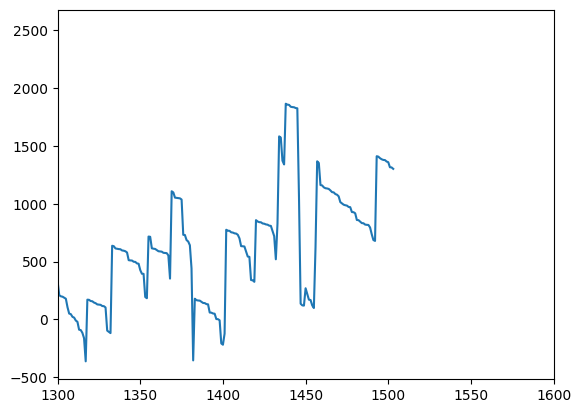

In [54]:
df = pd.read_csv('/content/drive/MyDrive/Chase2387_Activity_20230531 (1).CSV')
price = df.pop('Description')
sum = np.cumsum(price)
sum = sum.reset_index(drop=True)
words = df.pop('Posting Date')
date = df.pop('Details')
plt.xlim(1300,1600)
plt.plot(sum)
print(sum)

In [55]:
def remove_non_letters(input_array):
    return [''.join(filter(str.isalpha, s)) for s in input_array]

result = remove_non_letters(words)
result = np.array(result)


In [56]:

# Create a HashingVectorizer instance
vectorizer = HashingVectorizer(n_features=10)

# Fit and transform the array of words
encoded_words = vectorizer.fit_transform(result).toarray()

encoded_words = np.array(encoded_words)

worddf = pd.DataFrame(encoded_words)

print(worddf)

        0    1    2    3    4    5    6    7    8    9
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1499  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0
1500  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0
1501  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
1502  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
1503  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0

[1504 rows x 10 columns]


In [57]:
Date = pd.DataFrame()
# Convert the date column to a datetime object
date = pd.to_datetime(date)

# Extract the month, day, and day of the week as a number
Date['month'] = date.dt.month
Date['day'] = date.dt.day
Date['day_of_week'] = date.dt.day_of_week

Date = Date.reset_index(drop=True)

print(Date)

      month  day  day_of_week
0         5   31            2
1         5   31            2
2         5   31            2
3         5   30            1
4         5   30            1
...     ...  ...          ...
1499     12   14            1
1500     12   14            1
1501     12   13            0
1502     12   13            0
1503     12   13            0

[1504 rows x 3 columns]


In [69]:
pricedf = pd.DataFrame(price)
pricedf = pricedf.rename(columns={'Description': 'Price'})
sumdf = pd.DataFrame(sum)
sumdf = sumdf.rename(columns={'Description': 'Sum'})
lagged = sumdf.rename(columns={'Sum': 'Target'})
sumdf = sumdf.reset_index(drop=True)
lagged = lagged.reset_index(drop=True)
pricedf = pricedf.reset_index(drop=True)

input = pd.concat([Date,worddf,pricedf,sumdf,lagged],axis=1)

input['Target'] = input['Target'].shift(periods=30)

input = input.dropna()

target = input.pop('Target')

print(input)

      month  day  day_of_week    0    1    2    3    4    5    6    7    8  \
30        5   18            3  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  0.0   
31        5   17            2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
32        5   17            2 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
33        5   16            1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
34        5   16            1 -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...     ...  ...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1499     12   14            1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1500     12   14            1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1501     12   13            0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1502     12   13            0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1503     12   13            0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        9   Price      Sum  
30    0.0  778.47   442.12  
31   

In [84]:
def create_sliding_windows(dataframe, window_size):
    windows = []
    for win in dataframe.rolling(window_size, axis=0):
        if win.shape[0] == window_size:
            windows.append(win.values)
    return windows

window_size = 30
windows = create_sliding_windows(input, window_size)
windows = np.array(windows)
#print(windows)

In [85]:
targetlist = target.tolist()
targetlist = targetlist[:len(windows)]
targetlist = np.array(targetlist)

In [86]:
# Create a Sequential model instance
model = Sequential()

# Add layers to the model using the add() method
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dropout(.2))
model.add(Dense(5, activation="gelu"))
model.add(Dropout(.2))
model.add(Dense(1))

# Compile the model
model.compile(loss="mse", optimizer="adam", metrics=["mae"])


In [ ]:

# Fit the model to the training data
history = model.fit(windows, targetlist, epochs=1000)

plt.plot(history.history["loss"], label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Epoch 1/1000
46/46 [==============================] - 17s 80ms/step - loss: 1384222.7500 - mae: 1039.2671
Epoch 2/1000
46/46 [==============================] - 3s 73ms/step - loss: 1380594.0000 - mae: 1037.6593
Epoch 3/1000
46/46 [==============================] - 3s 74ms/step - loss: 1377240.3750 - mae: 1036.1191
Epoch 4/1000
33/46 [====================>.........] - ETA: 1s - loss: 1418644.0000 - mae: 1055.1633

In [78]:
predictions = model.predict(windows)


46/46 [==============================] - 1s 3ms/step


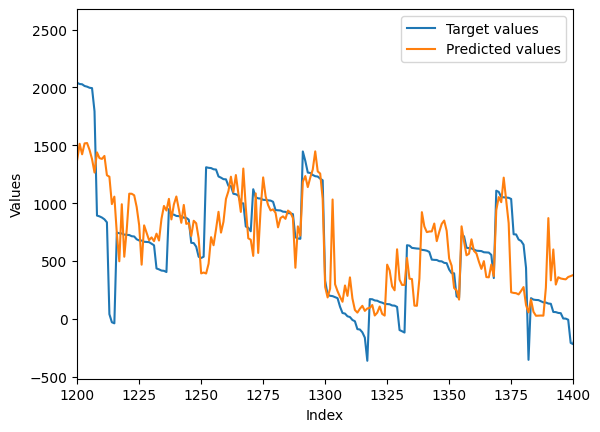

In [81]:
# Plot the target values
plt.plot(targetlist, label="Target values")

# Plot the predicted values
plt.plot(predictions, label="Predicted values")

# Add a legend and labels
plt.legend()
plt.xlabel("Index")
plt.ylabel("Values")

plt.xlim(1200,1400)
# Display the plot
plt.show()